### Grassy Knoll

Data format really wants something more refined than a pandas csv read but with a lot of delimiters specified, it works... its not speedy though

In [30]:
import os
import glob #python >= 3.5

import datetime
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline


In [31]:
### specify primary bulk figure parameters
fontsize = 20
labelsize = 16
#plotstyle = 'seaborn'
plt.style.use('seaborn-ticks')
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['ps.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['pdf.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.edgecolor'] = 'black'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.labelcolor'] = 'black'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['xtick.major.size'] = 4
mpl.rcParams['xtick.minor.size'] = 1
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 4
mpl.rcParams['ytick.minor.size'] = 1
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['xtick.color'] = 'black'

In [32]:
root_path = '/Users/bell/in_and_outbox/Ongoing_Analysis/2019_SailDrone_RadsIntercomparison/GrassyKnoll_PreSaildrone/'

swdata = {}
lwdata = {}

for filename in sorted(glob.iglob(root_path+'/*SW*.thin.txt', recursive=True), reverse=True):
    swdata.update({filename.split('/')[-1]: pd.read_csv(filename,header=None,
                                                        sep='"|,|SW Rn', engine='python',
                                                        usecols=[1,4],names=['time','sw'],
                                                        parse_dates=True,index_col='time')})
    

In [33]:
for filename in sorted(glob.iglob(root_path+'/*LW*.thin.txt', recursive=True), reverse=True):
    lwdata.update({filename.split('/')[-1]: pd.read_csv(filename,header=None,
                                                        sep='"|,|Rd|D|C|LW Rn', engine='python',
                                                        usecols=[1,4,6,8,10],names=['time','lwnet','c1','c2','lw'],
                                                        parse_dates=True,index_col='time')})

In [204]:
#be careful, dates near calendar day turn over sometimes are weird
spn1 = {}
for filename in sorted(glob.iglob(root_path+'/*A*.txt', recursive=True), reverse=True):
    spn1.update({filename.split('/')[-1]: pd.read_csv(filename,delimiter='\t',skiprows=4,
                                                      parse_dates=True,index_col='Time')})


In [307]:
#UW rad... needs 30min offset forward in time (done later in routine when timezone is addressed)
uwrad = {}
for filename in sorted(glob.iglob(root_path+'/*UW*.txt', recursive=True), reverse=True):
    uwrad.update({filename.split('/')[-1]: pd.read_csv(filename,delimiter='\s+',skiprows=71,usecols=[0,1,12],
                                                       names=['Date','Time','Radn'],
                                                      parse_dates=[['Date','Time']],index_col='Date_Time')})


### Plot Timeseries of Each Instrument including temperatures

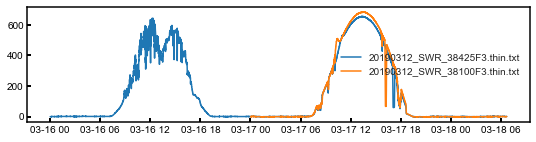

In [34]:
fig = plt.figure(1,figsize=(9,2.125))
ax1 = plt.subplot2grid((1, 1), (0, 0), colspan=1, rowspan=1)

for unit, value in swdata.items():
    plt.plot(value,label=unit)

plt.legend()


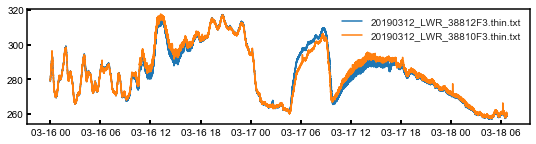

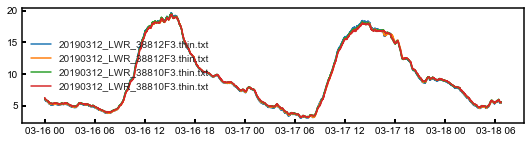

In [35]:
fig = plt.figure(1,figsize=(9,2.125))
ax1 = plt.subplot2grid((1, 1), (0, 0), colspan=1, rowspan=1)

for unit, value in lwdata.items():
    plt.plot(value.lw,label=unit)

plt.legend()

fig = plt.figure(2,figsize=(9,2.125))
ax1 = plt.subplot2grid((1, 1), (0, 0), colspan=1, rowspan=1)

for unit, value in lwdata.items():
    plt.plot(value.c1,label=unit)
    plt.plot(value.c2,label=unit)

plt.legend()



### Difference Plots

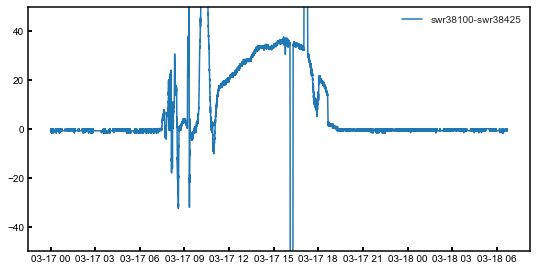

In [37]:
fig = plt.figure(1,figsize=(9,4.5))
ax1 = plt.subplot2grid((1, 1), (0, 0), colspan=1, rowspan=1)

plt.plot(swdata['20190312_SWR_38100F3.thin.txt']-swdata['20190312_SWR_38425F3.thin.txt'],label='swr38100-swr38425')
ax1.set_ylim([-50,50])

plt.legend()


In [ ]:
lwdata.keys()

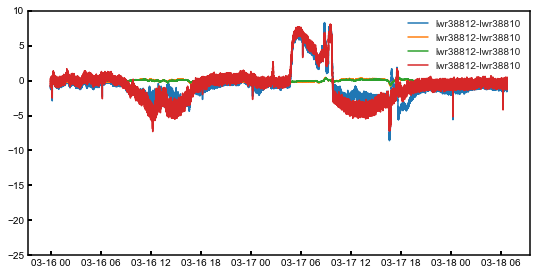

In [38]:
fig = plt.figure(1,figsize=(9,4.5))
ax1 = plt.subplot2grid((1, 1), (0, 0), colspan=1, rowspan=1)

plt.plot(lwdata['20190312_LWR_38812F3.thin.txt']-lwdata['20190312_LWR_38810F3.thin.txt'],label='lwr38812-lwr38810')
ax1.set_ylim([-25,10])
plt.legend()

### One-One Plots

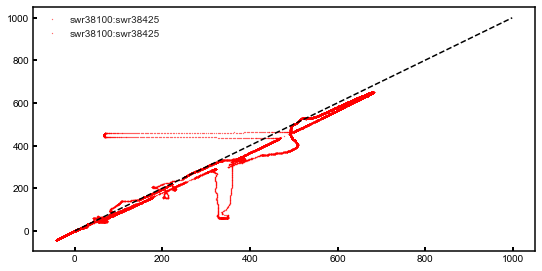

In [101]:
fig = plt.figure(1,figsize=(9,4.5))
ax1 = plt.subplot2grid((1, 1), (0, 0), colspan=1, rowspan=1)

plt.plot(swdata['20190312_SWR_38100F3.thin.txt']['2019-03-17'].resample('1s').mean(),
         swdata['20190312_SWR_38425F3.thin.txt']['2019-03-17'].resample('1s').mean(),
         '.r',markersize=.5,
         label='swr38100:swr38425')
plt.plot(range(0,1000),range(0,1000),'k--')
plt.legend()


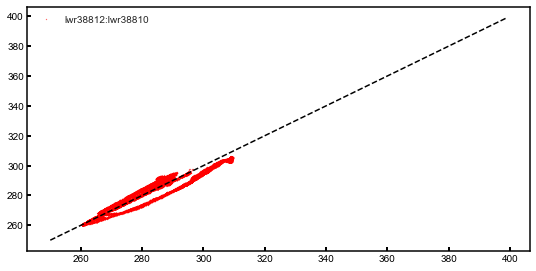

In [102]:
fig = plt.figure(1,figsize=(9,4.5))
ax1 = plt.subplot2grid((1, 1), (0, 0), colspan=1, rowspan=1)

plt.plot(lwdata['20190312_LWR_38812F3.thin.txt']['2019-03-17']['lw'].resample('1s').mean(),
         lwdata['20190312_LWR_38810F3.thin.txt']['2019-03-17']['lw'].resample('1s').mean(),
         '.r',markersize=.5,
         label='lwr38812:lwr38810')
plt.plot(range(250,400),range(250,400),'k--')
plt.legend()


### Calculate SZA as this is more comparable paramter than irradiance

In [43]:
from pysolar.solar import *
import datetime

### example below
date = datetime.datetime.now(tz=datetime.timezone.utc)
print(get_altitude(42.206, -71.382, date))
date = datetime.datetime(2007, 2, 18, 15, 13, 1, 130320, tzinfo=datetime.timezone.utc)
print(get_altitude(42.206, -71.382, date))

25.06143356867787
30.91446827139096


In [44]:
### seattle, wa
lat = 47.6602
lon = -122.3321


In [45]:
for unit, value in swdata.items():
    count=0
    value['sza'] = np.nan
    value = value.tz_localize('US/Pacific')
    for index, row in value.iterrows():
        value['sza'][index] = get_altitude(lat, lon, index)
        if (count % 3600) == 0:
            print(row)
        count+=1
        
    swdata[unit] = value

sw     -1.008000
sza   -41.154966
Name: 2019-03-16 00:00:00-07:00, dtype: float64
sw      0.624000
sza   -43.985885
Name: 2019-03-16 01:00:00-07:00, dtype: float64
sw      0.624000
sza   -43.245348
Name: 2019-03-16 01:59:59-07:00, dtype: float64
sw     -0.192000
sza   -39.097603
Name: 2019-03-16 02:59:59-07:00, dtype: float64
sw      1.440000
sza   -32.325887
Name: 2019-03-16 03:59:59-07:00, dtype: float64
sw      0.624000
sza   -23.823402
Name: 2019-03-16 04:59:59-07:00, dtype: float64
sw     -0.192000
sza   -14.305973
Name: 2019-03-16 05:59:59-07:00, dtype: float64
sw     0.624000
sza   -4.301325
Name: 2019-03-16 06:59:58-07:00, dtype: float64
sw     35.708000
sza     5.924518
Name: 2019-03-16 07:59:58-07:00, dtype: float64
sw     128.721000
sza     15.612445
Name: 2019-03-16 08:59:58-07:00, dtype: float64
sw     283.743000
sza     24.605231
Name: 2019-03-16 09:59:58-07:00, dtype: float64
sw     478.744000
sza     32.276916
Name: 2019-03-16 10:59:58-07:00, dtype: float64
sw     579.9

In [308]:
for unit, value in spn1.items():
    count=0
    value['sza'] = np.nan
    try:
        value = value.tz_localize('UTC').tz_convert('US/Pacific')
    except:
        value = value.tz_convert('US/Pacific')
    spn1[unit] = value
    
for unit, value in uwrad.items():
    count=0
    value['sza'] = np.nan
    try:
        value = value.tz_localize('UTC').tz_convert('Etc/GMT+7')
        value.index = value.index+datetime.timedelta(seconds=1800)
    except:
        value = value.tz_convert('Etc/GMT+7')
        
    uwrad[unit] = value

In [46]:
#only need to calculate sza once really and wrt longwave its less a need
"""
for unit, value in lwdata.items():
    count=0
    value['sza'] = np.nan
    value = value.tz_localize('US/Pacific')
    for index, row in value.iterrows():
        value['sza'][index] = get_altitude(lat, lon, index)
        if (count % 3600) == 0:
            print(row)
        count+=1
        
    lwdata[unit] = value
"""

"\nfor unit, value in lwdata.items():\n    count=0\n    value['sza'] = np.nan\n    value = value.tz_localize('US/Pacific')\n    for index, row in value.iterrows():\n        value['sza'][index] = get_altitude(lat, lon, index)\n        if (count % 3600) == 0:\n            print(row)\n        count+=1\n        \n    lwdata[unit] = value\n"

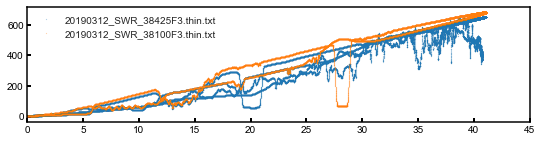

In [47]:
fig = plt.figure(1,figsize=(9,2.125))
ax1 = plt.subplot2grid((1, 1), (0, 0), colspan=1, rowspan=1)

for unit, value in swdata.items():
    plt.plot(value.sza,value.sw,'.',markersize=.25,label=unit)
    
ax1.set_xlim([0,45])

plt.legend()


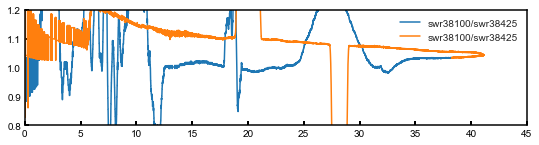

In [119]:
fig = plt.figure(1,figsize=(9,2.125))
ax1 = plt.subplot2grid((1, 1), (0, 0), colspan=1, rowspan=1)

plt.plot(swdata['20190312_SWR_38425F3.thin.txt']['2019-03-17 00:00:00':'2019-03-17 12:00:00'].resample('1s').mean().sza,
         swdata['20190312_SWR_38100F3.thin.txt']['2019-03-17 00:00:00':'2019-03-17 12:00:00'].resample('1s').mean().sw/swdata['20190312_SWR_38425F3.thin.txt']['2019-03-17 00:00:00':'2019-03-17 12:00:00'].resample('1s').mean().sw,label='swr38100/swr38425')
plt.plot(swdata['20190312_SWR_38425F3.thin.txt']['2019-03-17 12:00:00':'2019-03-18 00:00:00'].resample('1s').mean().sza,
         swdata['20190312_SWR_38100F3.thin.txt']['2019-03-17 12:00:00':'2019-03-18 00:00:00'].resample('1s').mean().sw/swdata['20190312_SWR_38425F3.thin.txt']['2019-03-17 12:00:00':'2019-03-18 00:00:00'].resample('1s').mean().sw,label='swr38100/swr38425')
ax1.set_xlim([0,45])
ax1.set_ylim([.8,1.2])

plt.legend()


### Load/Plot collocated SPN1's (2x)

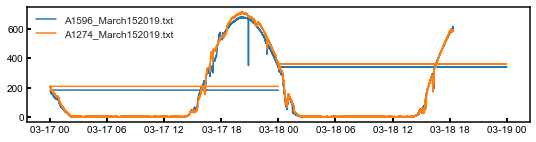

In [91]:
fig = plt.figure(1,figsize=(9,2.125))
ax1 = plt.subplot2grid((1, 1), (0, 0), colspan=1, rowspan=1)

for unit, value in spn1.items():
    plt.plot(value.Total['2019-03-17':'2019-03-18'],label=unit)

plt.legend()


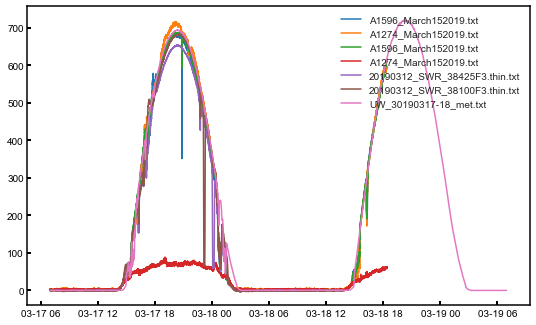

In [309]:
fig = plt.figure(1,figsize=(9,5.5))
ax1 = plt.subplot2grid((1, 1), (0, 0), colspan=1, rowspan=1)

for unit, value in spn1.items():
    plt.plot(value.Total['2019-03-17':'2019-03-18'],label=unit)

for unit, value in spn1.items():
    plt.plot(value.Diffuse['2019-03-17':'2019-03-18'],label=unit)

for unit, value in swdata.items():
    plt.plot(value.sw['2019-03-17':'2019-03-18'],label=unit)

for unit, value in uwrad.items():
    plt.plot(value.Radn['2019-03-17':'2019-03-18'],label=unit)
    
plt.legend()


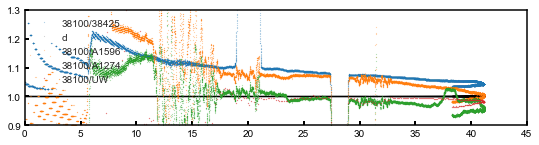

In [313]:
### Choose 38100 as truth (matches a recently cal'd spn1 and is in the middle of data envelope)

fig = plt.figure(1,figsize=(9,2.125))
ax1 = plt.subplot2grid((1, 1), (0, 0), colspan=1, rowspan=1)

plt.plot(swdata['20190312_SWR_38100F3.thin.txt']['2019-03-17 12:00:00':'2019-03-18 00:00:00'].resample('1s').mean().sza,
         (swdata['20190312_SWR_38100F3.thin.txt']['2019-03-17 12:00:00':'2019-03-18 00:00:00'].resample('1s').mean().sw/
         swdata['20190312_SWR_38425F3.thin.txt']['2019-03-17 12:00:00':'2019-03-18 00:00:00'].resample('1s').mean().sw),
         '.',markersize=.25,label='38100/38425')
plt.plot(swdata['20190312_SWR_38100F3.thin.txt']['2019-03-17 12:00:00':'2019-03-18 12:00:00'].resample('1s').mean().sza,
         (swdata['20190312_SWR_38100F3.thin.txt']['2019-03-17 12:00:00':'2019-03-18 12:00:00'].resample('1s').mean().sw/
         swdata['20190312_SWR_38100F3.thin.txt']['2019-03-17 12:00:00':'2019-03-18 12:00:00'].resample('1s').mean().sw),
         'k.',markersize=.125,label='d')
plt.plot(swdata['20190312_SWR_38100F3.thin.txt']['2019-03-17 12:00:00':'2019-03-18 00:00:00'].resample('1s').mean().sza,
         (swdata['20190312_SWR_38100F3.thin.txt']['2019-03-17 12:00:00':'2019-03-18 00:00:00'].resample('1s').mean().sw/
         spn1['A1596_March152019.txt']['2019-03-17 12:00:00':'2019-03-18 00:00:00'].resample('1s').mean().Total),
         '.',markersize=.25,label='38100/A1596')
plt.plot(swdata['20190312_SWR_38100F3.thin.txt']['2019-03-17 12:00:00':'2019-03-18 00:00:00'].resample('1s').mean().sza,
         (swdata['20190312_SWR_38100F3.thin.txt']['2019-03-17 12:00:00':'2019-03-18 00:00:00'].resample('1s').mean().sw/
         spn1['A1274_March152019.txt']['2019-03-17 12:00:00':'2019-03-18 00:00:00'].resample('1s').mean().Total),
         '.',markersize=.25,label='38100/A1274')
plt.plot(swdata['20190312_SWR_38100F3.thin.txt']['2019-03-17 12:00:00':'2019-03-18 00:00:00'].resample('1s').mean().sza,
         (swdata['20190312_SWR_38100F3.thin.txt']['2019-03-17 12:00:00':'2019-03-18 00:00:00'].resample('1s').mean().sw/
         uwrad['UW_30190317-18_met.txt']['2019-03-17 12:00:00':'2019-03-18 00:00:00'].resample('1s').mean().Radn),
         '.',markersize=.5,label='38100/UW')
ax1.set_ylim([0.9,1.3])
ax1.set_xlim([0,45])

plt.legend()


In [310]:
uwrad

{'UW_30190317-18_met.txt':                            Radn  sza
 Date_Time                           
 2019-03-16 06:37:00-07:00   0.0  NaN
 2019-03-16 06:38:00-07:00   0.0  NaN
 2019-03-16 06:39:00-07:00   0.0  NaN
 2019-03-16 06:40:00-07:00   0.0  NaN
 2019-03-16 06:41:00-07:00   0.0  NaN
 2019-03-16 06:42:00-07:00   0.0  NaN
 2019-03-16 06:43:00-07:00   0.0  NaN
 2019-03-16 06:44:00-07:00   0.0  NaN
 2019-03-16 06:45:00-07:00   0.0  NaN
 2019-03-16 06:46:00-07:00   0.0  NaN
 2019-03-16 06:47:00-07:00   0.0  NaN
 2019-03-16 06:48:00-07:00   0.0  NaN
 2019-03-16 06:49:00-07:00   0.0  NaN
 2019-03-16 06:50:00-07:00   0.0  NaN
 2019-03-16 06:51:00-07:00   0.0  NaN
 2019-03-16 06:52:00-07:00   0.0  NaN
 2019-03-16 06:53:00-07:00   0.0  NaN
 2019-03-16 06:54:00-07:00   0.0  NaN
 2019-03-16 06:55:00-07:00   0.0  NaN
 2019-03-16 06:56:00-07:00   0.0  NaN
 2019-03-16 06:57:00-07:00   0.0  NaN
 2019-03-16 06:58:00-07:00   0.0  NaN
 2019-03-16 06:59:00-07:00   0.0  NaN
 2019-03-16 07:00:00-07: